# Kernel Density Estimation

A univariate kernel density estimator is implemented in `sm.nonparametric.KDEUnivariate`.
We show the following:

* Basic usage, how to fit the estimator.
* The effect of varying the bandwidth with the `bw` argument.
* The various kernel functions (the `kernel` argument).

In [17]:
%matplotlib inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import mixture_rvs

## A univariate example

In [2]:
np.random.seed(12345) # Seed random number generator for reproducible results

We create a bimodal distribution - a mixture of two normal distributions with locations at `-1` and `1`.

In [3]:
# Location and scale for the two distributions
dist1_loc, dist1_scale, weight1 = -1 , .5, .25
dist2_loc, dist2_scale, weight2 = 1 , .5, .75

# Sample from a micture of distributions
obs_dist1 = mixture_rvs(prob=[weight1, weight2], 
                        size=250, 
                        dist=[stats.norm, stats.norm],
                        kwargs = (dict(loc=dist1_loc, scale=dist1_scale),
                                  dict(loc=dist2_loc, scale=dist2_scale)))

The simplest non-parametric technique for density estimation is the histogram.

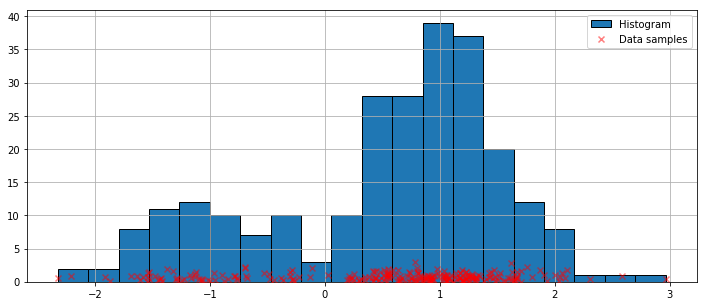

In [4]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.scatter(obs_dist1, np.abs(np.random.randn(obs_dist1.size)), 
           zorder = 15, color = 'red', marker = 'x', alpha = 0.5,
          label = 'Data samples')
lines = ax.hist(obs_dist1, bins = 20, edgecolor = 'k', label = 'Histogram')
ax.legend(loc = 'best')
ax.grid(True, zorder = -5)

## Fitting with the default arguments

The histogram above is discontinuous, for a continuous probability density function,
we can use kernel density estimation.

Initialize a Univariate Kernel Density Estimator using `KDEUnivariate`.

In [5]:
kde = sm.nonparametric.KDEUnivariate(obs_dist1)
kde.fit() # Estimate the densities

Create a figure of the fit and the true distribution.

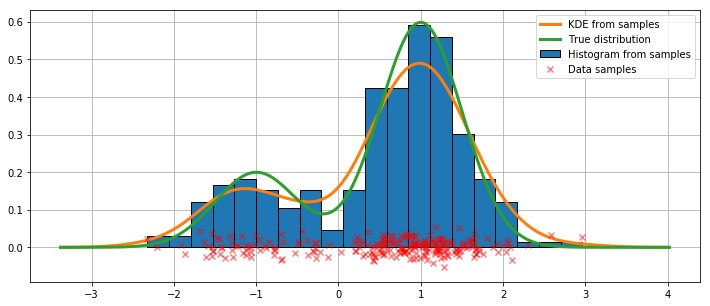

In [6]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.hist(obs_dist1, bins=20, normed=True, label = 'Histogram from samples', 
        zorder = 5, edgecolor = 'k')

# Plot the KDE as fitted using the default arguments
ax.plot(kde.support, kde.density, lw=3, label = 'KDE from samples', zorder = 10)

# Plot the true distribution
true_values = (stats.norm.pdf(loc = dist1_loc, scale = dist1_scale, x = kde.support)*weight1
              + stats.norm.pdf(loc = dist2_loc, scale = dist2_scale, x = kde.support)*weight2)
ax.plot(kde.support, true_values, lw = 3, label = 'True distribution', zorder = 15)

# Plot the samples
ax.scatter(obs_dist1, np.zeros_like(obs_dist1) + np.random.randn(obs_dist1.size)/50, 
           marker='x', color = 'red', zorder = 20, label = 'Data samples', alpha = 0.5)

ax.legend(loc = 'best')
ax.grid(True, zorder = -5)

The results above are from the default arguments. We can vary the bandwidth of the kernel.

## Varying the bandwidth using the `bw` argument

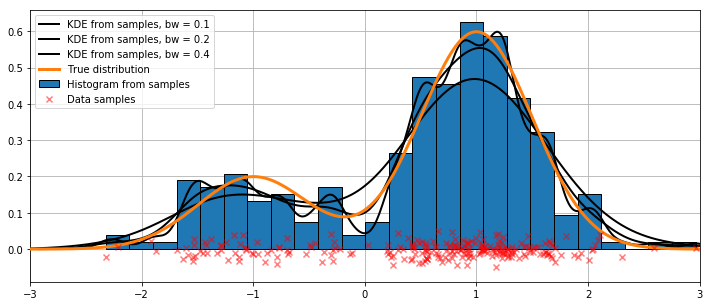

In [7]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.hist(obs_dist1, bins=25, normed=True, label = 'Histogram from samples', 
        zorder = 5, edgecolor = 'k')

# Plot the KDE for various bandwidths
for bandwidth in [0.1, 0.2, 0.4]:
    kde.fit(bw=bandwidth) # Estimate the densities
    ax.plot(kde.support, kde.density, lw=2, color = 'k', 
            label = 'KDE from samples, bw = {}'.format(round(bandwidth, 2)), zorder = 10)

# Plot the true distribution
true_values = (stats.norm.pdf(loc = dist1_loc, scale = dist1_scale, x = kde.support)*weight1
              + stats.norm.pdf(loc = dist2_loc, scale = dist2_scale, x = kde.support)*weight2)
ax.plot(kde.support, true_values, lw = 3, label = 'True distribution', zorder = 15)

# Plot the samples
ax.scatter(obs_dist1, np.zeros_like(obs_dist1) + np.random.randn(obs_dist1.size)/50, 
           marker='x', color = 'red', zorder = 20, label = 'Data samples', alpha = 0.5)

ax.legend(loc = 'best')
ax.set_xlim([-3, 3])
ax.grid(True, zorder = -5)

## Comparing kernel functions

Above, a Gaussian kernel was used. Several kernels are available.

In [8]:
from statsmodels.nonparametric.kde import kernel_switch
list(kernel_switch.keys())

['gau', 'epa', 'uni', 'tri', 'biw', 'triw', 'cos', 'cos2']

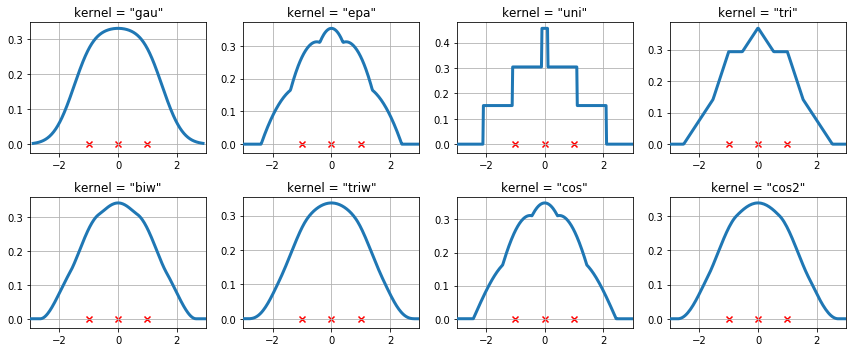

In [9]:
# Create three equidistant points
obs_dist1 = np.linspace(-1, 1, 3)
kde = sm.nonparametric.KDEUnivariate(obs_dist1)

# Create a figure
fig = plt.figure(figsize=(12, 5))

# Enumerate every option for the kernel
for i, kernel in enumerate(kernel_switch.keys()):
    
    # Create a subplot, set the title
    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title('kernel = "{}"'.format(kernel))
    
    # Fit the model (estimate densities)
    kde.fit(kernel=kernel, fft=False, gridsize=500)
    
    # Create the plot
    ax.plot(kde.support, kde.density, lw=3, label = 'KDE from samples', zorder = 10)
    ax.scatter(obs_dist1, np.zeros_like(obs_dist1), marker='x', color = 'red')
    plt.grid(True, zorder = -5); ax.set_xlim([-3, 3])
    
plt.tight_layout()

## A more difficult case

The fit is not always perfect. See the example below.

In [10]:
obs_dist2 = mixture_rvs([.25, .75], size=10000, dist=[stats.norm, stats.beta],
            kwargs = (dict(loc=-1, scale=.5), dict(loc=1 ,scale=1, args=(1, .5))))

kde2 = sm.nonparametric.KDEUnivariate(obs_dist2)
kde2.fit()

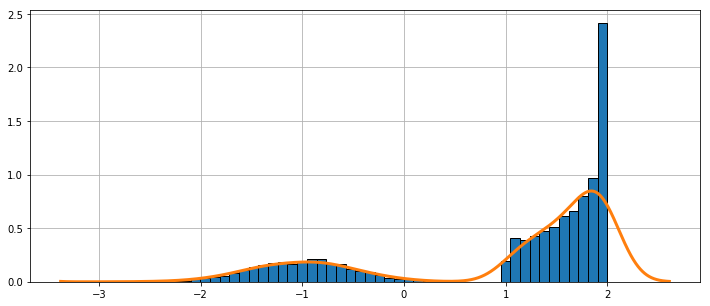

In [11]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.hist(obs_dist2, bins=50, normed=True, edgecolor = 'k', zorder=4)
ax.plot(kde2.support, kde2.density, lw=3, zorder = 7)
ax.grid(True, zorder = -5)

## The KDE is a distribution

Since the KDE is a distribution, we can access methods such as:

- `entropy`
- `evaluate`
- `cdf`
- `icdf`
- `sf`
- `cumhazard`

In [12]:
obs_dist3 = mixture_rvs([.25, .75], size=1000, dist=[stats.norm, stats.norm],
                kwargs = (dict(loc=-1, scale=.5), dict(loc=1, scale=.5)))
kde3 = sm.nonparametric.KDEUnivariate(obs_dist3)
kde3.fit()

In [13]:
kde3.entropy

1.3167709883922554

In [14]:
kde3.evaluate(-1)

array([ 0.17250329])

### Cumulative distribution, it's inverse, and the survival function

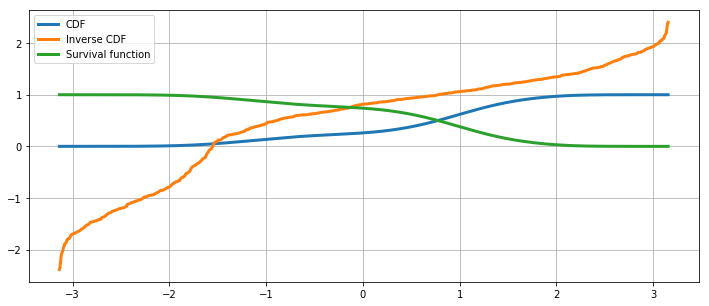

In [15]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

ax.plot(kde3.support, kde3.cdf, lw= 3, label='CDF')
ax.plot(kde3.support, kde3.icdf, lw=3, label = 'Inverse CDF')
ax.plot(kde3.support, kde3.sf, lw=3, label = 'Survival function')
ax.legend(loc = 'best')
ax.grid(True, zorder = -5)

### The Cumulative Hazard Function

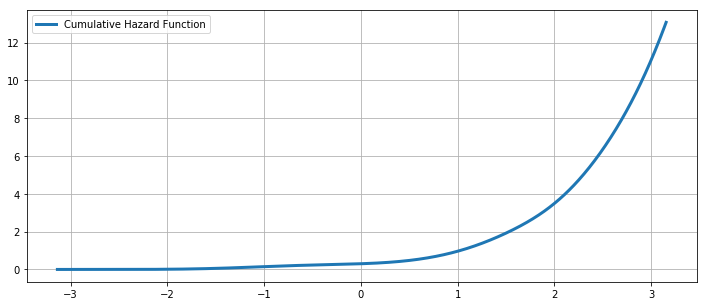

In [16]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.plot(kde3.support, kde3.cumhazard, lw=3, label = 'Cumulative Hazard Function')
ax.legend(loc = 'best')
ax.grid(True, zorder = -5)